### **Step 0**: Import Library

In [ ]:
# ── 기본 데이터 처리 ────────────────────────
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# ── 시각화 ───────────────────────────────────
import matplotlib.pyplot as plt

---

### **Step 1**: Data Loading and Preprocessing

In [2]:
data = np.load("output_summary.npz")

# 2. 내부 key 목록 확인
print(data.files)

# DataFrame으로 변환
df = pd.DataFrame({key: data[key] for key in data.files if not key.startswith("BHP") and key != "TVERDPLGEO"})

# 출력 변수(TVERDPLGEO, BHP_WELL들)도 따로 불러올 수 있음
TVERDPLGEO = data["TVERDPLGEO"]
bhp_all = np.stack([data["BHP_WELL1"], data["BHP_WELL2"], data["BHP_WELL3"], data["BHP_WELL4"]], axis=1)

df = df.rename(columns={c: c.replace("/", "\\") for c in df.columns})

['$k_v$', '$C_{/mathrm{por}}$', '$h_{/mathrm{aq}}$', '$S_1$', '$S_2$', '$S_3$', '$S_4$', '$C_R$', '$S_{wi,2}$', '$S_{gi,2}$', '$k_{rwgc,2}$', '$n_{w,2}$', '$k_{rgwc,2}$', '$n_{g,2}$', '$S_{wi,3}$', '$S_{gi,3}$', '$k_{rwgc,3}$', '$n_{w,3}$', '$k_{rgwc,3}$', '$n_{g,3}$', '$E_1$', '$/nu_1$', '$E_2$', '$/nu_2$', '$E_3$', '$/nu_3$', '$E_4$', '$/nu_4$', 'TVERDPLGEO', 'BHP_WELL1', 'BHP_WELL2', 'BHP_WELL3', 'BHP_WELL4']


In [3]:
BHP_scaled = MinMaxScaler(feature_range=(-1, 1)).fit_transform(bhp_all.reshape(bhp_all.shape[0], -1))
TVERDPLGEO_scaled = MinMaxScaler(feature_range=(-1, 1)).fit_transform(TVERDPLGEO.reshape(TVERDPLGEO.shape[0], -1))
param_df_scaled = MinMaxScaler(feature_range=(-1, 1)).fit_transform(df)

BHP_mean = BHP_scaled.mean(axis=1)
TVERDPLGEO_mean = TVERDPLGEO_scaled.mean(axis=1)

---

### **Step 2**: Sensitivity Analysis

#### **Step 2-1**: t-test

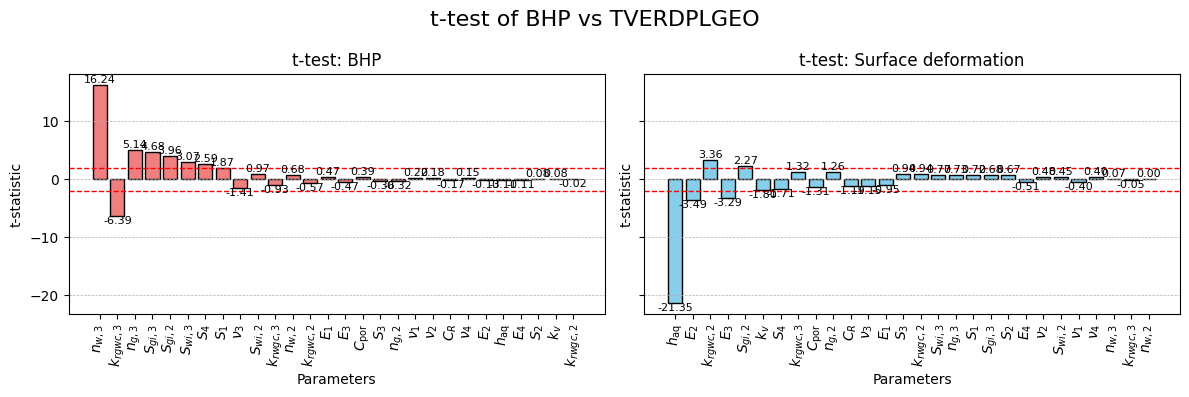

In [4]:
from Sensitivity_Analysis import ttest_param_vs_target

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

t_bhp = ttest_param_vs_target(
    param_array=param_df_scaled, target_array=BHP_mean, feature_names=df.columns,
    target_label="BHP", ax=axes[0], bar_color="lightcoral"
)

t_insar = ttest_param_vs_target(
    param_array=param_df_scaled, target_array=TVERDPLGEO_mean, feature_names=df.columns,
    target_label="Surface deformation", ax=axes[1], bar_color="skyblue"
)

plt.suptitle("t-test of BHP vs TVERDPLGEO", fontsize=16)
plt.tight_layout()
plt.show()


#### **Step 2-2**: Randomforest Feature Importance

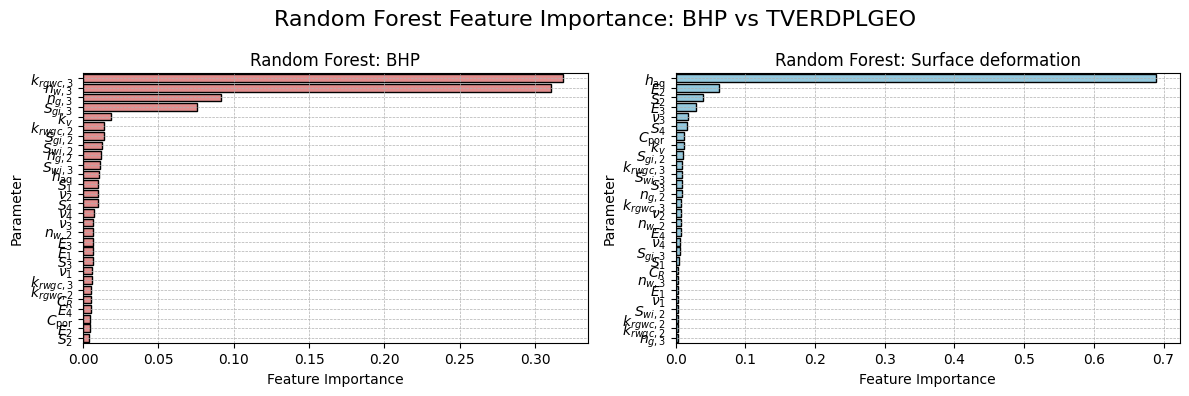

In [5]:
from Sensitivity_Analysis import rf_importance_param_vs_target, plot_rf_importance

# 1️⃣ Feature importance 계산
imp_bhp = rf_importance_param_vs_target(param_df_scaled, BHP_mean, df.columns)
imp_insar = rf_importance_param_vs_target(param_df_scaled, TVERDPLGEO_mean, df.columns)

# 2️⃣ 그림 그리기
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_rf_importance(imp_bhp, target_label="BHP", ax=axes[0], color="lightcoral")
plot_rf_importance(imp_insar, target_label="Surface deformation", ax=axes[1], color="skyblue")

plt.suptitle("Random Forest Feature Importance: BHP vs TVERDPLGEO", fontsize=16)
plt.tight_layout()
plt.show()


#### **Step 2-3**: Lasso Coefficient

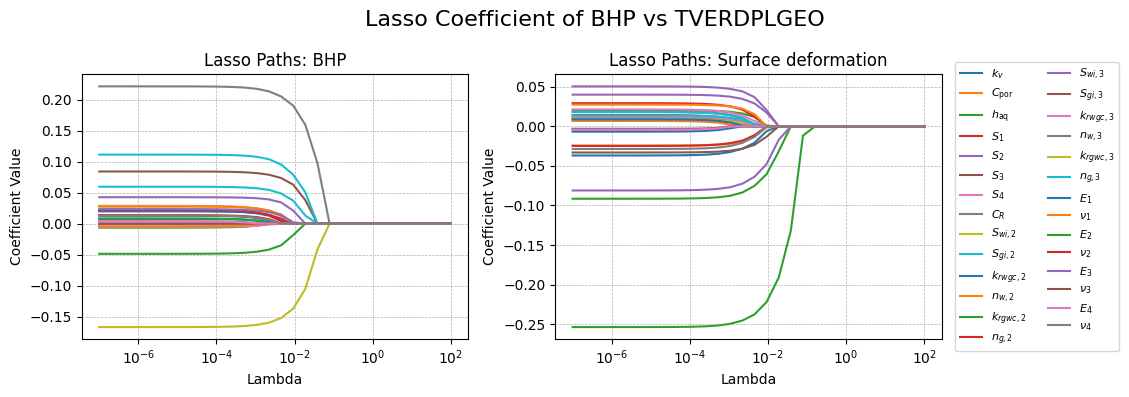

In [6]:
from Sensitivity_Analysis import lasso_paths_param_vs_target,plot_lasso_paths

# 1) BHP
lambdas_bhp, coefs_bhp, feat_names = lasso_paths_param_vs_target(
    param_df_scaled, BHP_mean, df.columns, lambdas=np.logspace(-7, 2, 30)
)

# 2) TVERDPLGEO
lambdas_insar, coefs_insar, _ = lasso_paths_param_vs_target(
    param_df_scaled, TVERDPLGEO_mean, df.columns, lambdas=np.logspace(-7, 2, 30)
)

# 3) 그리기
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

plot_lasso_paths(
    lambdas_bhp, coefs_bhp, feat_names, ax=axes[0],
    title="Lasso Paths: BHP", show_legend=False,   # 오른쪽에만 legend
)

plot_lasso_paths(
    lambdas_insar, coefs_insar, feat_names, ax=axes[1],
    title="Lasso Paths: Surface deformation", show_legend=True, legend_ncol=2,
)

plt.suptitle("Lasso Coefficient of BHP vs TVERDPLGEO", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()


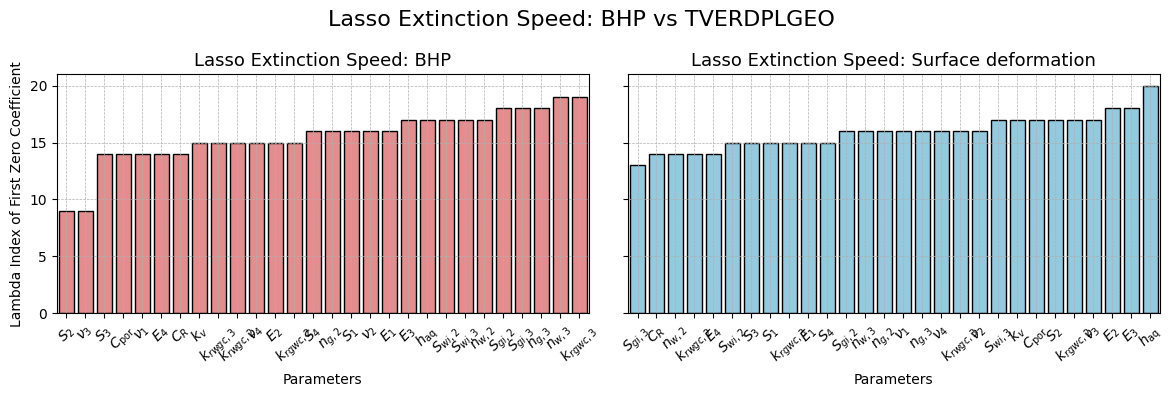

In [7]:
from Sensitivity_Analysis import (
    compute_lasso_extinction_index,
    plot_lasso_extinction,
)
import matplotlib.pyplot as plt

# 1️⃣ extinction index 계산
zero_idx_TVERDPLGEO = compute_lasso_extinction_index(coefs_insar, lambdas_insar)
zero_idx_BHP = compute_lasso_extinction_index(coefs_bhp, lambdas_bhp)

# 2️⃣ 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

plot_lasso_extinction(zero_idx_BHP, df.columns, target_label="BHP", ax=axes[0], color="lightcoral")
plot_lasso_extinction(zero_idx_TVERDPLGEO, df.columns, target_label="Surface deformation", ax=axes[1], color="skyblue")

plt.suptitle("Lasso Extinction Speed: BHP vs TVERDPLGEO", fontsize=16)
plt.tight_layout()
plt.show()


#### **Step 2-4**: Correlation

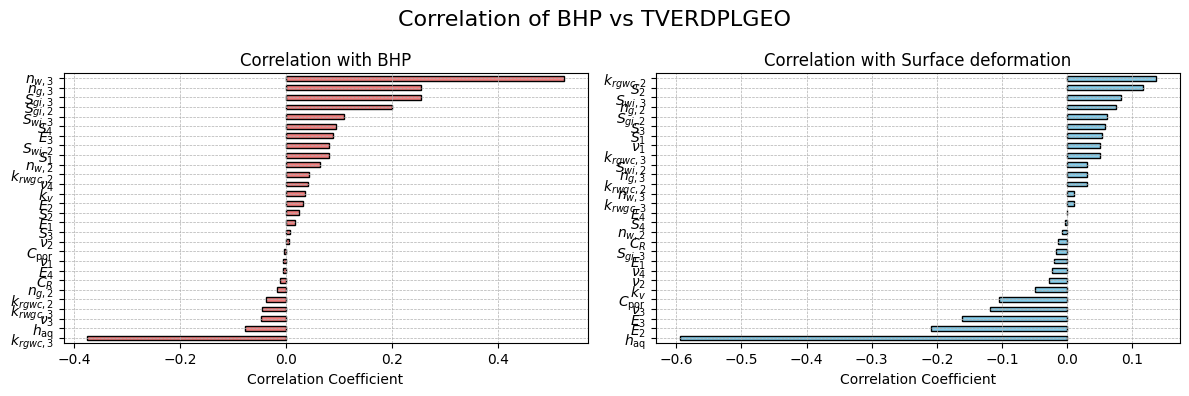

In [8]:
from Sensitivity_Analysis import corr_param_vs_targets, plot_corr_two_targets

corr_bhp, corr_insar = corr_param_vs_targets(
    param_df=df,                  # 파라미터만 있는 DF
    target_bhp=BHP_mean,
    target_insar=TVERDPLGEO_mean,
)

plot_corr_two_targets(
    corr_bhp,
    corr_insar,
    label_bhp="BHP",
    label_insar="Surface deformation",
)


---

### **Step 3**: Integrated Sensitivity Anaylsis

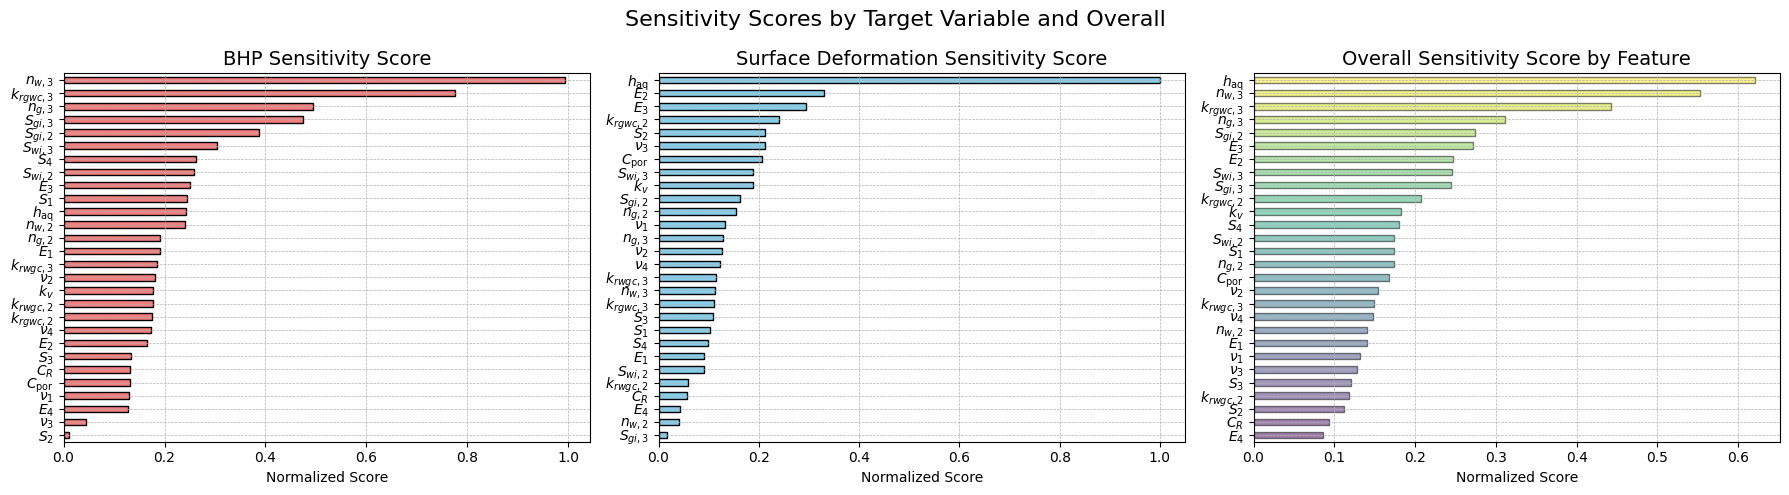

In [9]:
from Sensitivity_Analysis import build_sensitivity_table, plot_sensitivity_summary


df_scaled = build_sensitivity_table(
    feature_names=df.columns,
    t_bhp=t_bhp,
    t_insar=t_insar,
    imp_bhp=imp_bhp,
    imp_insar=imp_insar,
    ext_bhp=zero_idx_BHP,
    ext_insar=zero_idx_TVERDPLGEO,
    corr_bhp=corr_bhp,
    corr_insar=corr_insar,
)

plot_sensitivity_summary(df_scaled)


---